# Space Shuttle Main Engine (RS-25)

Comparison with SSME data. I think the SSME is film cooled, so this data should be taken with a grain of salt.

Issues:
- I can't understand how they get the coolant mass flow rates they state. That would require absurd coolant velocities on the order of 500 m/s.

### References:

- [1] - Pizzarelli et al, 2013, Coupled Wall Heat Conduction and Coolant Flow Analysis for Liquid Rocket Engines (https://doi.org/10.2514/1.B34533)

In [15]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import json

data = json.load(open("data/ssme.json"))

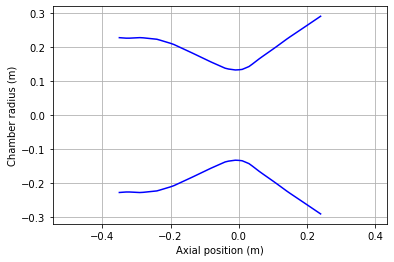

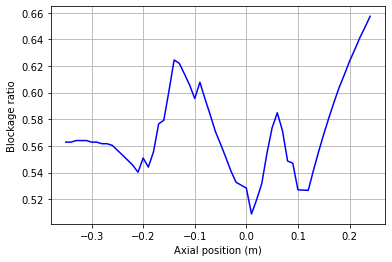

In [16]:
# Combustion chamber [1]
OF = 6.0
p0_chamber = 225.87 

xs = data["Chamber contour"]["x (m)"]
ys = data["Chamber contour"]["y (m)"]

# Cooling channels [1]
wall_material = bam.Material(k = 316)
number_of_channels = 390
mdot_coolant = 14.306 
p0_coolant_in = 445.47e5
T_coolant_in = 53.89

def channel_height(x):
    # Note I'm using Pizarelli's 'recasted' channel exit height
    return np.interp(x, data["Channel width"]["x (m)"], data["Channel width"]["w (m)"])
    
def wall_thickness(x):
    return np.interp(x, data["Wall thickness"]["x (m)"], data["Wall thickness"]["t (m)"])

def blockage_ratio(x):
    channel_width = np.interp(x, data["Channel width"]["x (m)"], data["Channel width"]["w (m)"])
    rib_thickness = np.interp(x, data["Rib thickness"]["x (m)"], data["Rib thickness"]["t (m)"])
    return rib_thickness/(channel_width + rib_thickness)
    
plt.plot(xs, ys, color = 'blue')
plt.plot(xs, -np.array(ys), color = 'blue')
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Chamber radius (m)")
plt.axis('equal')
plt.show()

plt.plot(xs, blockage_ratio(xs), color = 'blue')
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Blockage ratio")
plt.show()

In [17]:
# Use pypropep to get chamber temperature
ppp.init()
p_froz = ppp.FrozenPerformance()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

# Add propellants by mass fractions
p_froz.add_propellants_by_mass([(lox, OF), (lh2, 1)])

# Adiabatic combustion using chamber pressure                      
p_froz.set_state(P = p0_chamber/1e5, Pe = 1)   

# Get results - use throat conditions for gamma and cp! Otherwise the perfect gas model deviates a lot from equilibrium calculations.
gamma = p_froz.properties[1].Isex    # pyrpopep uses 'Isex' for the ratio of specific heats. Index 1 means throat conditions
cp = 1000*p_froz.properties[1].Cp    # Cp is given in kJ/kg/K, we want J/kg/K
T0_chamber = p_froz.properties[0].T  # Index 0 means chamber conditions

print(f"Chamber temperature = {T0_chamber} K")

Loaded 1921 thermo species
Loaded 1031 propellants
Chamber temperature = 2372.761724994633 K


In [18]:
# Cantera for exhaust gas
gas = ct.Solution('gri30.yaml')
gas.TPY = T0_chamber, p0_chamber, f"H2:{1}, O2:{OF}"
gas.equilibrate("TP")

cp = gas.cp
gamma = cp / gas.cv

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity

In [19]:
# CoolProp for coolant transport properties
def Pr_coolant(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

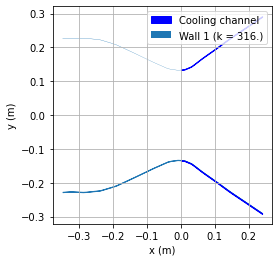

In [22]:
# Set up everything for bamboo
geometry = bam.Geometry(xs = xs, 
                        ys = ys)

perfect_gas = bam.PerfectGas(gamma = gamma, 
                             cp = cp)   

chamber_conditions = bam.ChamberConditions(p0 = p0_chamber, 
                                           T0 = T0_chamber)

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

cooling_jacket = bam.CoolingJacket(T_coolant_in = T_coolant_in,                           
                                   p0_coolant_in = p0_coolant_in, 
                                   coolant_transport = coolant_transport, 
                                   mdot_coolant = mdot_coolant, 
                                   configuration = "vertical", 
                                   channel_height = channel_height,
                                   number_of_channels = number_of_channels,
                                   blockage_ratio = blockage_ratio,
                                   xs = [-0.0, xs[-1]])

wall = bam.Wall(material = wall_material, 
                thickness = wall_thickness)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    cooling_jacket = cooling_jacket,
                    exhaust_transport = exhaust_transport,
                    walls = wall)

engine.plot()

In [29]:
# Run simulation
bamboo_data = engine.steady_heating_analysis(counterflow = True)

TypeError: steady_heating_analysis() got an unexpected keyword argument 'only_indexes'

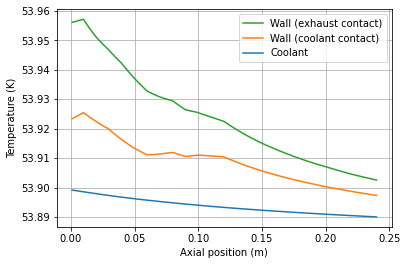

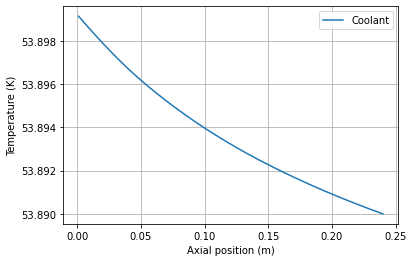

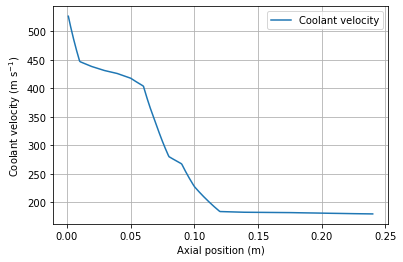

In [31]:
bam.plot.plot_temperatures(bamboo_data, only_indexes = [0,1,2])

bam.plot.plot_temperatures(bamboo_data, only_indexes = [0])
#plt.plot(data["Coolant temperature"]["x (m)"], data["Coolant temperature"]["T (K)"])
plt.show()

bam.plot.plot_coolant_velocity(bamboo_data)

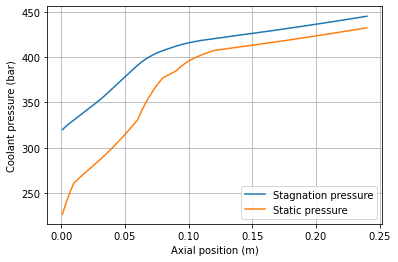

In [26]:
bam.plot.plot_jacket_pressure(bamboo_data)

In [ ]:
bam.plot.plot_q_per_area(bamboo_data)
bam.plot.plot_coolant_velocity(bamboo_data)
bam.plot.plot_coolant_density(bamboo_data)